# FairPredictor Examples
This file contains demo code for an extended version of the example in Readme.md (additionally handling more fairness over multiple groups),  and enforcing a range of fairness definition on COMPAS.

FairPredictor is a postprocessing approach for enforcing fairness, with support for a wide range of performance metrics and fairness criteria, and support for inferred attributes, i.e. it does not require access to protected attributes at test time. 
Under the hood, FairPredictor works by adjusting the decision boundary for each group individually. Where groups are not available, it makes use of inferred group membership to adjust decision boundaries.

The key idea underlying this toolkit is that for a wide range of use cases, the most suitable classifier should do more than maximize some form of accuracy.
We offer a general toolkit that allows different measures to be optimized and additional constraints to be imposed by tuning the behavior of a binary predictor on validation data.

For example, classifiers can be tuned to maximize performance for a wide range of metrics such as:

* Accuracy
* Balanced Accuracy
* F1 score
* MCC
* Custom utility functions

While also approximately satisfying a wide range of group constraints such as:

* Demographic Parity (The idea that positive decisions should occur at the same rates for all protected groups, for example for men at the same rate as for women)
* Equal Opportunity (The recall should be the same for all protected groups)
* Minimum recall constraints (The recall should be above a particular level for all groups)
* Minimum Precision constraints (The precision should be above a particular level for all groups)
* Custom Fairness Metrics

The full set of constraints and objectives can be seen in Readme.md 

In [1]:
# Load and train a baseline classifier

from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.fair import FairPredictor 
from autogluon.fair.utils import group_metrics as gm
train_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv')
test_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv')
predictor = TabularPredictor(label='class').fit(train_data=train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20221122_183017/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20221122_183017/"
AutoGluon Version:  0.6.1b20221122
Python Version:     3.7.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #59-Ubuntu SMP Mon Oct 17 18:53:30 UTC 2022
Train Data Rows:    39073
Train Data Columns: 14
Label Column: class
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [' <=50K', ' >50K']
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 =  >50K, class 0 =  <=50K
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive ( >50K) vs negative 

In [2]:
# Modify predictor to enforce fairness over the train_data with respect to groups given by the column 'sex'
fpredictor = FairPredictor(predictor,train_data,'sex')
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy,gm.demographic_parity,0.02)

In [3]:
# Evaluate on test data
fpredictor.predict(test_data)

0        <=50K
1        <=50K
2         >50K
3        <=50K
4        <=50K
         ...  
9764     <=50K
9765     <=50K
9766     <=50K
9767     <=50K
9768     <=50K
Length: 9769, dtype: object

In [4]:
# Evaluate a range of performance measures, and compare against original classifier on test data
fpredictor.evaluate(test_data, verbose= True)

,original,updated
Accuracy,0.876344,0.853823
Balanced Accuracy,0.795006,0.756022
F1 score,0.710728,0.649140
MCC,0.639568,0.567803
Precision,0.798708,0.753995
Recall,0.640207,0.569888
roc_auc,0.931334,0.827791


In [5]:
# Evaluate a range of performance measures, and compare against original classifier on test data
fpredictor.evaluate(test_data, verbose= True)

,original,updated
Accuracy,0.876344,0.853823
Balanced Accuracy,0.795006,0.756022
F1 score,0.710728,0.649140
MCC,0.639568,0.567803
Precision,0.798708,0.753995
Recall,0.640207,0.569888
roc_auc,0.931334,0.827791


In [6]:
# Evaluate against a range of standard fairness definitions and compare against original classifier on test data
fpredictor.evaluate_fairness(test_data, verbose= True)

,original,updated
Class Imbalance,0.195913,0.195913
Demographic Parity,0.164803,0.007727
Disparate Impact,0.329191,0.957524
Maximal Group Difference in Accuracy,0.092455,0.070943
Maximal Group Difference in Recall,0.063471,0.330265
Maximal Group Difference in Conditional Acceptance Rate,0.092771,1.050611
Maximal Group Difference in Acceptance Rate,0.023940,0.342428
Maximal Group Difference in Specificity,0.049672,0.057989
Maximal Group Difference in Conditional Rejectance Rate,0.047530,0.229275
Maximal Group Difference in Rejection Rate,0.092456,0.158566


In [7]:
# Evaluate a range of performance measures per group, and compare against original classifier on test data
fpredictor.evaluate_groups(test_data, verbose= True, return_original=True)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.876344           0.795006  0.710728  0.639568   
          Female             0.937671           0.783153  0.668821  0.642921   
          Male               0.845216           0.790053  0.718021  0.619412   
         Maximum difference  0.092455           0.006899  0.049200  0.023508   
updated  Overall             0.853823           0.756022  0.649140  0.567803   
          Female             0.900882           0.878437  0.647948  0.617657   
          Male               0.829938           0.742299  0.649491  0.577373   
         Maximum difference  0.070943           0.136138  0.001543  0.040284   

                             Precision    Recall   roc_auc  \
         Groups                                              
original Overall              0.798708  0.640207  0.931334   
          Female              0.778195  0.586402  0.947752   
          Male                0.802136  0.649873  0.913139   
         Maximum difference   0.023940  0.063471  0.034613   
updated  Overall              0.753995  0.569888  0.827791   
          Female              0.523560  0.849858  0.947752   
          Male                0.865988  0.519593  0.913139   
         Maximum difference   0.342428  0.330265  0.034613   

                             Number of Datapoints  Positive Count  \
         Groups                                                     
original Overall                           9769.0          2318.0   
          Female                           3289.0           353.0   
          Male                             6480.0          1965.0   
         Maximum difference                3191.0          1612.0   
updated  Overall                           9769.0          2318.0   
          Female                           3289.0           353.0   
          Male                             6480.0          1965.0   
         Maximum difference                3191.0          1612.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     7451.0             0.237281   
          Female                     2936.0             0.107327   
          Male                       4515.0             0.303241   
         Maximum difference          1579.0             0.195913   
updated  Overall                     7451.0             0.237281   
          Female                     2936.0             0.107327   
          Male                       4515.0             0.303241   
         Maximum difference          1579.0             0.195913   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.190193  
          Female                             0.080876  
          Male                               0.245679  
         Maximum difference                  0.164803  
updated  Overall                             0.179343  
          Female                             0.174217  
          Male                               0.181944  
         Maximum difference                  0.007727

In [8]:
#We can repeat the same analysis using the feature 'race' instead of 'sex'
fpredictor = FairPredictor(predictor,train_data, 'race')
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy, gm.demographic_parity, .02)

In [9]:
# Unlike the previous case, we find that demographic parity is still high on test data, although it is improved.
fpredictor.evaluate_fairness(test_data, verbose= True)

,original,updated
Class Imbalance,0.163744,0.163744
Demographic Parity,0.163999,0.120747
Disparate Impact,0.198634,0.485235
Maximal Group Difference in Accuracy,0.088415,0.039234
Maximal Group Difference in Recall,0.190982,0.393506
Maximal Group Difference in Conditional Acceptance Rate,0.996875,1.111982
Maximal Group Difference in Acceptance Rate,0.250000,0.401216
Maximal Group Difference in Specificity,0.063745,0.108973
Maximal Group Difference in Conditional Rejectance Rate,0.020621,0.251923
Maximal Group Difference in Rejection Rate,0.061988,0.119102


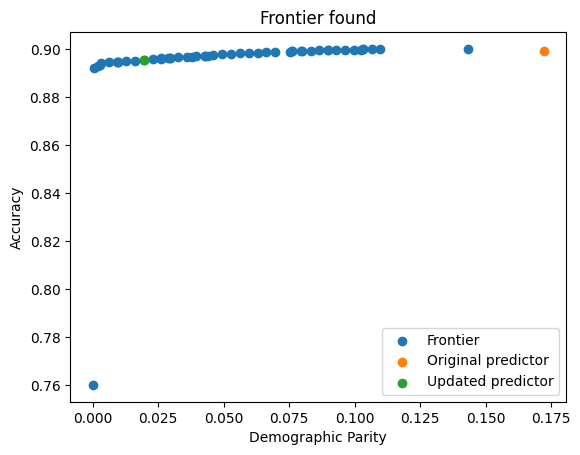

In [10]:
#To debug this, we can look at the Pareto Frontier of solutions considered, on the training set
fpredictor.plot_frontier() 

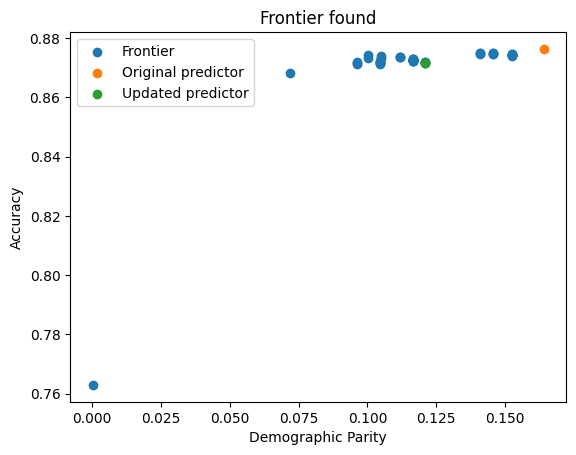

In [11]:
#and on the test set
fpredictor.plot_frontier(test_data) 

In [12]:
#We find that the demographic parity is very different on test data for a range of solutions found.
#By looking at the per group decomposition, we can find out why.
fpredictor.evaluate_groups(test_data, verbose=True)

,Accuracy,Balanced Accuracy,F1 score,MCC,Precision,Recall,roc_auc,Number of Datapoints,Positive Count,Negative Count,Positive Label Rate,Positive Prediction Rate
Groups,,,,,,,,,,,,
Overall,0.871737,0.796444,0.707311,0.629452,0.771268,0.653149,0.908686,9769.0,2318.0,7451.0,0.237281,0.200942
Amer-Indian-Eskimo,0.894309,0.737013,0.480000,0.425922,0.428571,0.545454,0.942370,123.0,11.0,112.0,0.089431,0.113821
Asian-Pac-Islander,0.859756,0.737310,0.629032,0.574152,0.829787,0.506493,0.909091,328.0,77.0,251.0,0.234756,0.143293
Black,0.898990,0.874005,0.666667,0.628923,0.552147,0.841121,0.954320,891.0,107.0,784.0,0.120090,0.182941
Other,0.864198,0.879577,0.620690,0.589369,0.473684,0.900000,0.963380,81.0,10.0,71.0,0.123457,0.234568
White,0.869039,0.796107,0.714845,0.636630,0.796512,0.648367,0.928179,8346.0,2113.0,6233.0,0.253175,0.206087
Maximum difference,0.039234,0.142564,0.234845,0.210708,0.401216,0.393506,0.054289,8265.0,2103.0,6162.0,0.163744,0.120747


In [13]:
#The groups with the smallest Positive Prediction Rate (American-Indian-Eskimo, and Asian-Pacific-Islander) 
# only have around 100-300 samples making it impossible to accurately evaluate demographic parity, while the
# group labelled 'Other' has even less data.
# Moreover, on training data we find that there are less than 350 people identified as American-Indian-Eskimo, 
# meaning that it is not possible to predict if the positive prediction rate will hold on new data. 
fpredictor.evaluate_groups(verbose=True)

,Accuracy,Balanced Accuracy,F1 score,MCC,Precision,Recall,roc_auc,Number of Datapoints,Positive Count,Negative Count,Positive Label Rate,Positive Prediction Rate
Groups,,,,,,,,,,,,
Overall,0.895708,0.836380,0.768611,0.704050,0.821160,0.722382,0.942213,39073.0,9369.0,29704.0,0.239782,0.210938
Amer-Indian-Eskimo,0.913545,0.921355,0.732143,0.706430,0.602941,0.931818,0.983648,347.0,44.0,303.0,0.126801,0.195965
Asian-Pac-Islander,0.897565,0.834744,0.790378,0.737129,0.920000,0.692771,0.968074,1191.0,332.0,859.0,0.278757,0.209908
Black,0.916183,0.932596,0.733668,0.713894,0.595918,0.954248,0.981941,3794.0,459.0,3335.0,0.120980,0.193727
Other,0.926154,0.957895,0.769231,0.756550,0.625000,1.000000,0.989649,325.0,40.0,285.0,0.123077,0.196923
White,0.892836,0.832120,0.770728,0.706116,0.844772,0.708618,0.956446,33416.0,8494.0,24922.0,0.254190,0.213221
Maximum difference,0.033318,0.125775,0.058235,0.050434,0.324082,0.307229,0.033203,33091.0,8454.0,24637.0,0.157777,0.019494


## Fairness on COMPAS using Inferred Attributes

We demonstrate how to enforce a wide range of fairness definitions on the COMPAS dataset. This dataset records paroles caught violating the terms of parole. As it measures who was caught, it is strongly influenced by policing and environmental biases, and should not be confused with a measurement of who actually violated their terms of parole. See [this paper](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/file/92cc227532d17e56e07902b254dfad10-Paper-round1.pdf) for a discussion of its limitations and caveats. 
We use it because it is a standard fairness dataset that captures such strong differences in outcome between people identified as African-American and everyone else, that classifiers trained on this dataset violate most definitions of fairness.

As many of the ethnic groups are too small for reliable statistical estimation, we only consider differences is in outcomes between African-Americans vs. everyone else (labeled as other).
We load and preprocess the COMPAS dataset, splitting it into three roughly equal partitions of train, validation, and test:

In [14]:
import numpy as np
import pandas as pd
from autogluon.fair import inferred_attribute_builder
all_data = pd.read_csv('https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv')
condensed_data=all_data[['sex','race','age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'age_cat', 'c_charge_degree','two_year_recid']].copy()
condensed_data.replace({'Caucasian':'Other', 'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'},inplace=True)
train=condensed_data.sample(frac=0.3, random_state=0)
val_and_test=condensed_data.drop(train.index)
val=val_and_test.sample(frac=0.5, random_state=0)
test=val_and_test.drop(val.index)

In [15]:
# To enforce fairness constraints without access to protected attributes at test time, we train two classifiers to infer the 2-year recidivism rate, and ethnicity.
  
predictor2, protected = inferred_attribute_builder(train, 'two_year_recid', 'race')


No path specified. Models will be saved in: "AutogluonModels/ag-20221122_183419/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20221122_183419/"
AutoGluon Version:  0.6.1b20221122
Python Version:     3.7.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #59-Ubuntu SMP Mon Oct 17 18:53:30 UTC 2022
Train Data Rows:    2164
Train Data Columns: 8
Label Column: two_year_recid
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9368.07 MB


In [16]:
# From these a single predictor that maximizes acuracy while reducing the demographic parity violation to less than 2.5% can be trained by running:

fpredictor=FairPredictor(predictor2, val, 'race', protected)
fpredictor.fit(gm.accuracy, gm.demographic_parity, 0.025)

In [17]:
#However, instead we will show how a family of fairness measures can be individually optimized. 
# The following code plots a table showing the change in accuracy and the fairness measure on a held-out test set as we decrease
# the fairness measure to less than 0.025 for all measures except for disparate impact which we raise to above 0.975.
# We define a helper function for evaluation:

def evaluate(fpredictor,use_metrics):
    "Print a table showing the accuracy drop that comes with enforcing fairness"
    extra_metrics= {**use_metrics, 'accuracy':gm.accuracy}
    collect=pd.DataFrame(columns=['Measure (original)', 'Measure (updated)', 'Accuracy (original)', 'Accuracy (updated)'])
    for d in use_metrics.items():
        if d[1].greater_is_better is False:
            fpredictor.fit(gm.accuracy,d[1], 0.025)
        else:
            fpredictor.fit(gm.accuracy,d[1], 1-0.025)
        tmp=fpredictor.evaluate_fairness(test,metrics=extra_metrics)
        collect.loc[d[1].name]=np.concatenate((np.asarray(tmp.loc[d[0]]), np.asarray(tmp.loc['accuracy'])), 0)
    return collect

In [18]:
#We can now contrast the behavior of a fair classifier that relies on access to the protected
# attribtute at test time with one that infers it.

# we first create a classifer using the protected attribute
predictor=TabularPredictor(label='two_year_recid').fit(train_data=train)

No path specified. Models will be saved in: "AutogluonModels/ag-20221122_183456/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20221122_183456/"
AutoGluon Version:  0.6.1b20221122
Python Version:     3.7.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #59-Ubuntu SMP Mon Oct 17 18:53:30 UTC 2022
Train Data Rows:    2164
Train Data Columns: 9
Label Column: two_year_recid
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    8816.44 MB


In [19]:
#Create a fair predictor object, using the attribute 'race' on validation data
fpredictor = FairPredictor(predictor, val, 'race')
#and then evaluate it
evaluate(fpredictor, gm.clarify_metrics)
#Note that Class Imbalance is a property of the dataset and can not be altered.

No solutions satisfy the constraint found, selecting the closest solution
No solutions satisfy the constraint found, selecting the closest solution


,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Class Imbalance,0.132203,0.132203,0.669307,0.665743
Demographic Parity,0.284547,0.021897,0.669307,0.654257
Disparate Impact,0.483630,0.992690,0.669307,0.674455
Maximal Group Difference in Accuracy,0.034418,0.036885,0.669307,0.672079
Maximal Group Difference in Recall,0.262693,0.022831,0.669307,0.665743
Maximal Group Difference in Conditional Acceptance Rate,0.487063,0.026553,0.669307,0.654653
Maximal Group Difference in Acceptance Rate,0.028665,0.021762,0.669307,0.661782
Maximal Group Difference in Specificity,0.233492,0.084970,0.669307,0.646733
Maximal Group Difference in Conditional Rejectance Rate,0.245411,0.043248,0.669307,0.651881
Maximal Group Difference in Rejection Rate,0.050946,0.067722,0.669307,0.665347


In [20]:
 # Now using infered attributes
fpredictor2 = FairPredictor(predictor2, val, 'race', protected)
evaluate(fpredictor2, gm.clarify_metrics)

No solutions satisfy the constraint found, selecting the closest solution
No solutions satisfy the constraint found, selecting the closest solution


,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Class Imbalance,0.132203,0.132203,0.664554,0.660990
Demographic Parity,0.231587,0.043766,0.664554,0.583762
Disparate Impact,0.575534,0.649784,0.664554,0.565941
Maximal Group Difference in Accuracy,0.045356,0.028988,0.664554,0.672871
Maximal Group Difference in Recall,0.182954,0.051383,0.664554,0.574653
Maximal Group Difference in Conditional Acceptance Rate,0.264872,0.019002,0.664554,0.594455
Maximal Group Difference in Acceptance Rate,0.037143,0.065752,0.664554,0.565545
Maximal Group Difference in Specificity,0.200868,0.050992,0.664554,0.620594
Maximal Group Difference in Conditional Rejectance Rate,0.173250,0.015031,0.664554,0.669703
Maximal Group Difference in Rejection Rate,0.079329,0.079745,0.664554,0.660990
